In [1]:
import weaviate
import json

client = weaviate.Client("http://localhost:8080") # <== if you use Docker-compose

schema = client.schema.get()
print(json.dumps(schema))

{"classes": [{"class": "Mails", "description": "Mails categorized as spam or ham", "invertedIndexConfig": {"bm25": {"b": 0.75, "k1": 1.2}, "cleanupIntervalSeconds": 60, "stopwords": {"additions": null, "preset": "en", "removals": null}}, "moduleConfig": {"text2vec-transformers": {"poolingStrategy": "masked_mean", "vectorizeClassName": true}}, "properties": [{"dataType": ["string"], "description": "Content of the mail", "moduleConfig": {"text2vec-transformers": {"skip": false, "vectorizePropertyName": false}}, "name": "text", "tokenization": "word"}, {"dataType": ["string"], "description": "The label of the mail", "moduleConfig": {"text2vec-transformers": {"skip": false, "vectorizePropertyName": false}}, "name": "label", "tokenization": "word"}], "shardingConfig": {"virtualPerPhysical": 128, "desiredCount": 1, "actualCount": 1, "desiredVirtualCount": 128, "actualVirtualCount": 128, "key": "_id", "strategy": "hash", "function": "murmur3"}, "vectorIndexConfig": {"skip": false, "cleanupInt

## Data Exploration

[Source: Kaggle - Spam Mails Dataset](https://www.kaggle.com/datasets/venky73/spam-mails-dataset)

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./data/spam_ham_dataset.csv",delimiter=",", index_col=0)
df.head()

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [41]:
if "label_num" in df.columns:
    df.drop(columns=['label_num'], inplace=True)
df.head()

,label,text
605,ham,Subject: enron methanol ; meter # : 988291\r\n...
2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
4685,spam,"Subject: photoshop , windows , office . cheap ..."
2030,ham,Subject: re : indian springs\r\nthis deal is t...


<AxesSubplot: >

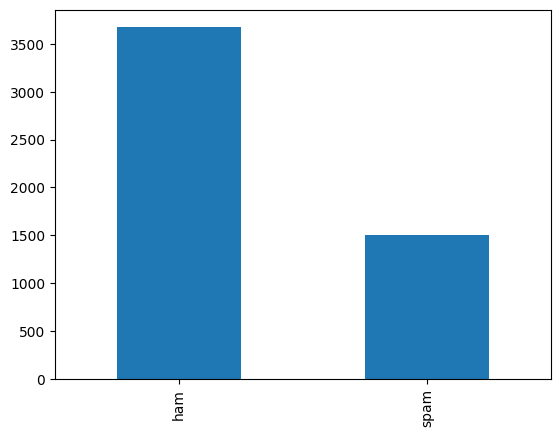

In [42]:
df.label.value_counts().plot.bar()

## Data Cleansing

In [43]:
def remove_subject_line(text: str) -> str:
    return " ".join(text.split("\n")[1:]).replace("\r", "")

In [44]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


def text_cleansing(text: str) -> str:
    # Remove subject header from mail
    text = remove_subject_line(text)
    # Tokenize text
    text_tokens = word_tokenize(text)
    # Filter out stopwords
    text_tokens_filtered = [token for token in text_tokens if not token.lower() in stopwords.words('english')]
    
    return " ".join(text_tokens_filtered)

In [46]:
from tqdm import tqdm
tqdm.pandas()
df.text = df['text'].progress_apply(text_cleansing)

100%|██████████| 5171/5171 [04:49<00:00, 17.83it/s]


In [68]:
# Drop rows with empty text
df = df[df['text'] != ""]

In [47]:
df.head()

,label,text
605,ham,"follow note gave monday , 4 / 3 / 00 { prelimi..."
2349,ham,( see attached file : hplnol 09 . xls ) - hpln...
3624,ham,"ho ho ho , ' around wonderful time year - - - ..."
4685,spam,abasements darer prudently fortuitous undergon...
2030,ham,deal book teco pvr revenue . understanding tec...


In [69]:
df_train=df.sample(frac=0.8,random_state=42)
df_test=df.drop(df_train.index)

In [70]:
client.schema.delete_all()

## Data Modelling

In [71]:
mail_schema = {
    "class": "mails",
    "description": "Mails categorized as spam or ham",
    "properties": [
        {
            "name": "text",
            "dataType": ["string"],
            "description": "Content of the mail"
        },
        {
            "name": "label",
            "dataType": ["string"],
            "description": "The label of the mail"        
        }
    ]
}

client.schema.create_class(mail_schema)
client.schema.get('mails')

{'class': 'Mails',
 'description': 'Mails categorized as spam or ham',
 'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
  'cleanupIntervalSeconds': 60,
  'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
 'moduleConfig': {'text2vec-transformers': {'poolingStrategy': 'masked_mean',
   'vectorizeClassName': True}},
 'properties': [{'dataType': ['string'],
   'description': 'Content of the mail',
   'moduleConfig': {'text2vec-transformers': {'skip': False,
     'vectorizePropertyName': False}},
   'name': 'text',
   'tokenization': 'word'},
  {'dataType': ['string'],
   'description': 'The label of the mail',
   'moduleConfig': {'text2vec-transformers': {'skip': False,
     'vectorizePropertyName': False}},
   'name': 'label',
   'tokenization': 'word'}],
 'shardingConfig': {'virtualPerPhysical': 128,
  'desiredCount': 1,
  'actualCount': 1,
  'desiredVirtualCount': 128,
  'actualVirtualCount': 128,
  'key': '_id',
  'strategy': 'hash',
  'function': 'murmur3'},

In [72]:
def add_mail(batch: weaviate.batch.Batch, mail: dict) -> str:
    mail_object = {
        "text": mail["text"],
        "label": mail["label"]
    }
    batch.add_data_object(data_object=mail_object, class_name="mails")

In [73]:
from tqdm import trange

with client.batch as batch:
    for i in trange(500):
        add_mail(batch, df_train.iloc[i])

        # if i % 1 == 0:
        batch.create_objects()

100%|██████████| 500/500 [06:46<00:00,  1.23it/s]


In [82]:
correct_predictions = 0
false_predictions = 0
no_result = 0

for i in trange(200):
    entry = df_test.iloc[i]
    try:
        weaviate_result = client.query.get(class_name='Mails', properties=["label"]).with_limit(1).with_near_text({"concepts": [entry.text], "certainty": 0.75}).do()

        mails = weaviate_result['data']['Get']['Mails']
        if len(mails) > 0:
            predicted_label = mails[0]['label']
            if predicted_label == entry['label']:
                correct_predictions +=1
            else:
                false_predictions +=1
        else:
            no_result += 1
    except Exception as e:
        print(f"Error at Index: {i}")

print(f"Correct: {correct_predictions}")
print(f"False: {false_predictions}")
print(f"Accuracy: {correct_predictions/(correct_predictions+false_predictions)}")
print(f"No result found: {no_result}")


  2%|▎         | 5/200 [00:00<00:04, 42.80it/s]

Error at Index: 0
Error at Index: 1
Error at Index: 2
Error at Index: 3
Error at Index: 4
Error at Index: 5
Error at Index: 6
Error at Index: 7


  7%|▋         | 14/200 [00:00<00:05, 33.75it/s]

Error at Index: 8
Error at Index: 9
Error at Index: 10
Error at Index: 11
Error at Index: 12
Error at Index: 13
Error at Index: 14


 11%|█         | 22/200 [00:00<00:05, 32.23it/s]

Error at Index: 15
Error at Index: 16
Error at Index: 17
Error at Index: 18
Error at Index: 19
Error at Index: 20
Error at Index: 21
Error at Index: 22


 14%|█▎        | 27/200 [00:00<00:04, 36.53it/s]

Error at Index: 23
Error at Index: 24
Error at Index: 25
Error at Index: 26
Error at Index: 27
Error at Index: 28
Error at Index: 29


 18%|█▊        | 35/200 [00:00<00:04, 35.89it/s]

Error at Index: 30
Error at Index: 31
Error at Index: 32
Error at Index: 33
Error at Index: 34
Error at Index: 35
Error at Index: 36
Error at Index: 37
Error at Index: 38


 22%|██▏       | 44/200 [00:01<00:04, 35.55it/s]

Error at Index: 39
Error at Index: 40
Error at Index: 41
Error at Index: 42
Error at Index: 43
Error at Index: 44
Error at Index: 45
Error at Index: 46


 24%|██▍       | 49/200 [00:01<00:04, 33.66it/s]

Error at Index: 47
Error at Index: 48
Error at Index: 49
Error at Index: 50
Error at Index: 51
Error at Index: 52


 28%|██▊       | 57/200 [00:01<00:04, 32.95it/s]

Error at Index: 53
Error at Index: 54
Error at Index: 55
Error at Index: 56
Error at Index: 57
Error at Index: 58
Error at Index: 59
Error at Index: 60


 33%|███▎      | 66/200 [00:01<00:03, 35.51it/s]

Error at Index: 61
Error at Index: 62
Error at Index: 63
Error at Index: 64
Error at Index: 65
Error at Index: 66
Error at Index: 67
Error at Index: 68


 38%|███▊      | 75/200 [00:02<00:03, 36.41it/s]

Error at Index: 69
Error at Index: 70
Error at Index: 71
Error at Index: 72
Error at Index: 73
Error at Index: 74
Error at Index: 75
Error at Index: 76
Error at Index: 77


 42%|████▎     | 85/200 [00:02<00:03, 37.53it/s]

Error at Index: 78
Error at Index: 79
Error at Index: 80
Error at Index: 81
Error at Index: 82
Error at Index: 83
Error at Index: 84
Error at Index: 85


 45%|████▌     | 90/200 [00:02<00:03, 36.34it/s]

Error at Index: 86
Error at Index: 87
Error at Index: 88
Error at Index: 89
Error at Index: 90
Error at Index: 91
Error at Index: 92
Error at Index: 93


 50%|█████     | 100/200 [00:02<00:02, 41.28it/s]

Error at Index: 94
Error at Index: 95
Error at Index: 96
Error at Index: 97
Error at Index: 98
Error at Index: 99
Error at Index: 100
Error at Index: 101


 52%|█████▎    | 105/200 [00:02<00:02, 39.50it/s]

Error at Index: 102
Error at Index: 103
Error at Index: 104
Error at Index: 105
Error at Index: 106
Error at Index: 107
Error at Index: 108
Error at Index: 109


 57%|█████▊    | 115/200 [00:03<00:02, 36.79it/s]

Error at Index: 110
Error at Index: 111
Error at Index: 112
Error at Index: 113
Error at Index: 114
Error at Index: 115
Error at Index: 116
Error at Index: 117


 60%|██████    | 121/200 [00:03<00:01, 40.76it/s]

Error at Index: 118
Error at Index: 119
Error at Index: 120
Error at Index: 121
Error at Index: 122
Error at Index: 123
Error at Index: 124
Error at Index: 125


 65%|██████▌   | 130/200 [00:03<00:01, 35.40it/s]

Error at Index: 126
Error at Index: 127
Error at Index: 128
Error at Index: 129
Error at Index: 130
Error at Index: 131


 70%|███████   | 140/200 [00:03<00:01, 41.37it/s]

Error at Index: 132
Error at Index: 133
Error at Index: 134
Error at Index: 135
Error at Index: 136
Error at Index: 137
Error at Index: 138
Error at Index: 139
Error at Index: 140
Error at Index: 141
Error at Index: 142


 75%|███████▌  | 150/200 [00:04<00:01, 41.56it/s]

Error at Index: 143
Error at Index: 144
Error at Index: 145
Error at Index: 146
Error at Index: 147
Error at Index: 148
Error at Index: 149
Error at Index: 150


 78%|███████▊  | 155/200 [00:04<00:01, 38.77it/s]

Error at Index: 151
Error at Index: 152
Error at Index: 153
Error at Index: 154
Error at Index: 155
Error at Index: 156
Error at Index: 157
Error at Index: 158


 84%|████████▍ | 169/200 [00:04<00:00, 39.06it/s]

Error at Index: 159
Error at Index: 160
Error at Index: 161
Error at Index: 162
Error at Index: 163
Error at Index: 164
Error at Index: 165
Error at Index: 166
Error at Index: 167
Error at Index: 168
Error at Index: 169


 87%|████████▋ | 174/200 [00:04<00:00, 36.81it/s]

Error at Index: 170
Error at Index: 171
Error at Index: 172
Error at Index: 173
Error at Index: 174
Error at Index: 175
Error at Index: 176
Error at Index: 177


 94%|█████████▍| 188/200 [00:05<00:00, 41.20it/s]

Error at Index: 178
Error at Index: 179
Error at Index: 180
Error at Index: 181
Error at Index: 182
Error at Index: 183
Error at Index: 184
Error at Index: 185
Error at Index: 186
Error at Index: 187


 96%|█████████▋| 193/200 [00:05<00:00, 38.87it/s]

Error at Index: 188
Error at Index: 189
Error at Index: 190
Error at Index: 191
Error at Index: 192
Error at Index: 193
Error at Index: 194
Error at Index: 195


100%|██████████| 200/200 [00:05<00:00, 37.06it/s]

Error at Index: 196
Error at Index: 197
Error at Index: 198
Error at Index: 199
Correct: 0
False: 0


ZeroDivisionError: division by zero